We show how to train a profitable RL agent on portfolio managemnt with EIIE algorithm on US stock market.

## Step 1: Import Packages
Modify the system path and load the corresponding packages and functions

In [39]:
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
ROOT = os.path.dirname(os.path.abspath("."))
sys.path.append(ROOT)
import torch
import argparse
import os.path as osp
from mmcv import Config
from trademaster.utils import replace_cfg_vals
from trademaster.nets.builder import build_net
from trademaster.environments.builder import build_environment
from trademaster.datasets.builder import build_dataset
from trademaster.agents.builder import build_agent
from trademaster.optimizers.builder import build_optimizer
from trademaster.losses.builder import build_loss
from trademaster.trainers.builder import build_trainer
from trademaster.transition.builder import build_transition
from trademaster.utils import plot
from trademaster.utils import set_seed
set_seed(2023)

## Step 2: Load Configs
Load default config from the file `configs/portfolio_management/portfolio_management_dj30_eiie_eiie_adam_mse.py`

In [42]:
parser = argparse.ArgumentParser(description='Download Alpaca Datasets')
parser.add_argument("--config", default=osp.join(ROOT, "configs", "portfolio_management", "portfolio_management_dj30_eiie_eiie_adam_mse.py"),
                    help="download datasets config file path")
parser.add_argument("--task_name", type=str, default="train")

args, _= parser.parse_known_args()
cfg = Config.fromfile(args.config)
task_name = args.task_name
cfg = replace_cfg_vals(cfg)

In [44]:
cfg

Config (path: C:\Users\KIIT\ML Python\AD Lab\Stock Shit idc\TradeMaster\configs\portfolio_management\portfolio_management_dj30_eiie_eiie_adam_mse.py): {'data': {'type': 'PortfolioManagementDataset', 'data_path': 'data/portfolio_management/dj30', 'train_path': 'data/portfolio_management/dj30/train.csv', 'valid_path': 'data/portfolio_management/dj30/valid.csv', 'test_path': 'data/portfolio_management/dj30/test.csv', 'tech_indicator_list': ['zopen', 'zhigh', 'zlow', 'zadjcp', 'zclose', 'zd_5', 'zd_10', 'zd_15', 'zd_20', 'zd_25', 'zd_30'], 'length_day': 10, 'initial_amount': 100000, 'transaction_cost_pct': 0.001, 'test_dynamic_path': 'data/portfolio_management/dj30/test_with_label.csv'}, 'environment': {'type': 'PortfolioManagementEIIEEnvironment'}, 'agent': {'type': 'PortfolioManagementEIIE', 'memory_capacity': 1000, 'gamma': 0.99, 'policy_update_frequency': 500}, 'trainer': {'type': 'PortfolioManagementEIIETrainer', 'epochs': 2, 'work_dir': 'work_dir/portfolio_management_dj30_eiie_eiie_a

## Step 3: Build Dataset

In [9]:
dataset = build_dataset(cfg)

In [53]:
print(dir(test_environment))


['__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_is_protocol', '_np_random', 'action_dim', 'action_space', 'action_space_shape', 'analysis_result', 'asset_memory', 'close', 'data', 'dataset', 'date_memory', 'day', 'df', 'df_path', 'evaualte', 'get_daily_return_rate', 'initial_amount', 'metadata', 'normalization', 'np_random', 'observation_space', 'portfolio_return_memory', 'portfolio_value', 'render', 'render_mode', 'reset', 'reward_range', 'save_asset_memory', 'save_portfolio_return_memory', 'spec', 'state', 'state_dim', 'state_space_shape', 'step', 'stock_dim', 'task', 'task_inde

In [55]:
print(dir(dataset))


['__add__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_is_protocol', 'data_path', 'get_styled_intervals_and_gives_new_index', 'initial_amount', 'kwargs', 'length_day', 'tech_indicator_list', 'test_dynamic_path', 'test_path', 'train_path', 'transaction_cost_pct', 'valid_path']


In [57]:
try:
    test_df = test_environment.df
    print(test_df.head())  # Inspect the dataframe
except AttributeError:
    print("`df` attribute is not accessible.")


         date        open        high         low       close       adjcp  \
0  2021-01-04  133.520004  133.610001  126.760002  129.410004  128.453430   
0  2021-01-04  231.250000  231.250000  223.669998  226.660004  217.989258   
0  2021-01-04  121.300003  121.800003  116.849998  118.040001  116.058220   
0  2021-01-04  210.000000  210.199997  202.490005  202.720001  202.720001   
0  2021-01-04  183.000000  185.979996  180.250000  182.149994  176.713684   

    tic     zopen     zhigh      zlow    zadjcp    zclose      zd_5     zd_10  \
0  AAPL  0.031760  0.032455 -0.020478 -0.007392 -0.024719  0.031420  0.017758   
0  AMGN  0.020251  0.020251 -0.013192 -0.038254 -0.014179  0.000856 -0.004266   
0   AXP  0.027618  0.031854 -0.010081 -0.016789 -0.023737  0.007930 -0.002330   
0    BA  0.035912  0.036898 -0.001135  0.000000 -0.052976  0.051490  0.065741   
0   CAT  0.004667  0.021027 -0.010431 -0.029845  0.000714 -0.012649 -0.014598   

      zd_15     zd_20     zd_25     zd_30  
0  0.0

In [59]:
# Add placeholders for predictions
test_df["predicted_zhigh"] = 0.0  # Placeholder for normalized high predictions
test_df["predicted_zlow"] = 0.0   # Placeholder for normalized low predictions
test_df["predicted_high"] = 0.0  # Placeholder for actual high predictions
test_df["predicted_low"] = 0.0   # Placeholder for actual low predictions

# Confirm the changes
print(test_df.head())


         date        open        high         low       close       adjcp  \
0  2021-01-04  133.520004  133.610001  126.760002  129.410004  128.453430   
0  2021-01-04  231.250000  231.250000  223.669998  226.660004  217.989258   
0  2021-01-04  121.300003  121.800003  116.849998  118.040001  116.058220   
0  2021-01-04  210.000000  210.199997  202.490005  202.720001  202.720001   
0  2021-01-04  183.000000  185.979996  180.250000  182.149994  176.713684   

    tic     zopen     zhigh      zlow  ...      zd_5     zd_10     zd_15  \
0  AAPL  0.031760  0.032455 -0.020478  ...  0.031420  0.017758  0.002323   
0  AMGN  0.020251  0.020251 -0.013192  ...  0.000856 -0.004266  0.001206   
0   AXP  0.027618  0.031854 -0.010081  ...  0.007930 -0.002330  0.000971   
0    BA  0.035912  0.036898 -0.001135  ...  0.051490  0.065741  0.083935   
0   CAT  0.004667  0.021027 -0.010431  ... -0.012649 -0.014598 -0.014490   

      zd_20     zd_25     zd_30  predicted_zhigh  predicted_zlow  \
0 -0.010486 

In [51]:
# Build Dataset
dataset = build_dataset(cfg)

# Build test environment
test_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="test"))

# Check for dataset access in the test environment
try:
    test_df = test_environment.dataset.data  # Common attribute for datasets
except AttributeError:
    raise AttributeError("Cannot find dataset in the test environment. Check the API.")

# Add placeholders for predictions in the dataset
test_df["predicted_zhigh"] = 0.0  # Placeholder for normalized high predictions
test_df["predicted_zlow"] = 0.0   # Placeholder for normalized low predictions
test_df["predicted_high"] = 0.0   # Placeholder for denormalized high predictions
test_df["predicted_low"] = 0.0    # Placeholder for denormalized low predictions


AttributeError: Cannot find dataset in the test environment. Check the API.

## Step 4: Build Reinforcement Learning Environments

In [62]:
train_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="train"))
valid_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="valid"))
test_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="test"))

In [63]:
train_environment.df.head()

,date,open,high,low,close,adjcp,tic,zopen,zhigh,zlow,zadjcp,zclose,zd_5,zd_10,zd_15,zd_20,zd_25,zd_30
0,2012-01-04,14.642857,14.810000,14.617143,14.765714,12.643501,AAPL,-0.008320,0.002999,-0.010062,-0.143726,0.005374,-0.010348,-0.011415,0.002751,-0.061124,-0.072128,-0.126481
0,2012-01-04,64.099998,64.129997,63.400002,63.759998,49.393219,AMGN,0.005332,0.005803,-0.005646,-0.225326,-0.005459,0.007794,-0.008521,-0.008222,-0.017393,-0.031253,-0.042012
0,2012-01-04,48.020000,48.380001,47.400002,48.240002,41.672607,AXP,-0.004561,0.002902,-0.017413,-0.136140,-0.003100,0.004561,-0.004885,-0.017185,-0.029824,-0.045096,-0.052918
0,2012-01-04,74.099998,74.599998,73.589996,74.330002,60.821106,BA,-0.003094,0.003632,-0.009956,-0.181742,0.001482,0.002922,-0.007421,-0.004776,-0.002812,-0.013054,-0.001687
0,2012-01-04,93.410004,95.510002,93.410004,94.849998,70.945084,CAT,-0.015182,0.006958,-0.015182,-0.252029,0.009257,0.010322,-0.004803,-0.010627,-0.001714,-0.005438,0.006133


In [66]:
# Modify the test_environment dataframe to include prediction placeholders
test_environment.df["predicted_zhigh"] = 0.0  # Placeholder for normalized high predictions
test_environment.df["predicted_zlow"] = 0.0   # Placeholder for normalized low predictions
test_environment.df["predicted_high"] = 0.0  # Placeholder for actual high predictions
test_environment.df["predicted_low"] = 0.0   # Placeholder for actual low predictions


## Step 5: Build Net 
Update information on the state and action dimension. Crreate networks and optimizer for EIIE.

In [69]:
action_dim = train_environment.action_dim # 29
state_dim = train_environment.state_dim # 11
input_dim = len(train_environment.tech_indicator_list)
time_steps = train_environment.time_steps

cfg.act.update(dict(input_dim=input_dim, time_steps=time_steps))
cfg.cri.update(dict(input_dim=input_dim, action_dim= action_dim, time_steps=time_steps))

act = build_net(cfg.act)
cri = build_net(cfg.cri)
act_optimizer = build_optimizer(cfg, default_args=dict(params=act.parameters()))
cri_optimizer = build_optimizer(cfg, default_args=dict(params=cri.parameters()))

## Step 6: Build Loss Function

In [72]:
criterion = build_loss(cfg)

## Step 7: Build Transition

In [75]:
transition = build_transition(cfg)


## Step 8: Build Agent

In [78]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent = build_agent(cfg, default_args=dict(action_dim=action_dim,state_dim=state_dim,time_steps = time_steps,act=act,cri=cri,act_optimizer=act_optimizer,cri_optimizer = cri_optimizer,criterion=criterion,transition = transition,device = device))

## Step 9: Build Trainer
Build trainer from config and create work directionary to save the result, model and config

In [81]:
trainer = build_trainer(cfg, default_args=dict(train_environment=train_environment,valid_environment=valid_environment,test_environment=test_environment,agent=agent,device=device))
work_dir = os.path.join(ROOT, cfg.trainer.work_dir)

if not os.path.exists(work_dir):
    os.makedirs(work_dir)
cfg.dump(osp.join(work_dir, osp.basename(args.config)))

In [34]:
trainer.df.head()

AttributeError: 'PortfolioManagementEIIETrainer' object has no attribute 'df'

In [83]:
# Example: Updating the trainer to populate predictions
def populate_predictions(self):
    # Assuming your model's prediction method outputs normalized predictions
    normalized_predictions = self.agent.predict(self.test_environment)

    # Denormalize predictions based on your logic
    self.test_environment.df["predicted_zhigh"] = normalized_predictions["zhigh"]
    self.test_environment.df["predicted_zlow"] = normalized_predictions["zlow"]

    # Example logic for denormalization (replace with actual scaling logic)
    self.test_environment.df["predicted_high"] = (
        self.test_environment.df["zhigh_mean"] + 
        self.test_environment.df["zhigh_std"] * normalized_predictions["zhigh"]
    )
    self.test_environment.df["predicted_low"] = (
        self.test_environment.df["zlow_mean"] + 
        self.test_environment.df["zlow_std"] * normalized_predictions["zlow"]
    )

    # Save updated dataframe for analysis
    self.test_environment.df.to_csv("test_predictions.csv", index=False)


In [87]:
import pandas as pd

def populate_predictions(test_environment, agent, save_to_file=True):
    """
    Populates the test environment with predictions and saves them to a CSV file.
    
    Args:
        test_environment (object): The test environment object containing the dataset.
        agent (object): The trained agent used to make predictions.
        save_to_file (bool): Whether to save the predictions to a CSV file.
    
    Returns:
        pd.DataFrame: The test DataFrame with predictions added.
    """

    # Access the test environment's dataframe
    test_df = test_environment.df

    # Assuming the agent has a predict method that returns predictions for 'zhigh' and 'zlow'
    predictions = agent.predict(test_environment)

    # Add placeholders for predictions
    test_df["predicted_zhigh"] = predictions["zhigh"]
    test_df["predicted_zlow"] = predictions["zlow"]

    # Example denormalization (if applicable, adjust as needed)
    # Denormalize the predicted high and low prices based on your dataset's mean and std
    test_df["predicted_high"] = (
        test_df["zhigh_mean"] + test_df["zhigh_std"] * test_df["predicted_zhigh"]
    )
    test_df["predicted_low"] = (
        test_df["zlow_mean"] + test_df["zlow_std"] * test_df["predicted_zlow"]
    )

    # Save to CSV if required
    if save_to_file:
        test_df.to_csv("test_predictions.csv", index=False)
        print("Predictions have been populated and saved to 'test_predictions.csv'.")
    else:
        print("Predictions populated, but not saved to a file.")

    return test_df


# Usage:
# Assuming you have a test_environment object and a trained agent object
test_df_with_predictions = populate_predictions(test_environment, agent)
print(test_df_with_predictions.head())  # Inspect the results


AttributeError: 'PortfolioManagementEIIE' object has no attribute 'predict'

NameError: name 'model' is not defined

Test Best Episode
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
|  14.658484%  |   1.305274  | 0.719105%  |  6.742038%   |
+--------------+-------------+------------+--------------+


AttributeError: 'PortfolioManagementEIIETrainer' object has no attribute 'populate_predictions'

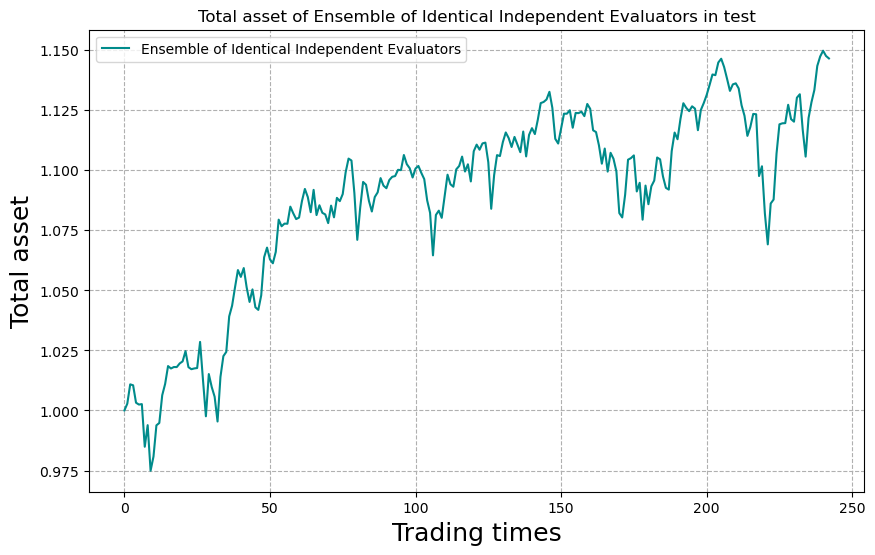

In [85]:
trainer.test()
trainer.populate_predictions()


## Step 10: RL Agent Training
Train the EIIE agent based on the config and save results in workdir

In [117]:
trainer.train_and_valid

Train Episode: [1/2]


KeyboardInterrupt: 

## Step 11: RL Agent Testing

In [ ]:
trainer.test();

In [ ]:
plot(trainer.test_environment.save_asset_memory(),alg="EIIE")

In [55]:
print(test_results.shape)
print(test_results)

(243,)
[ 0.00000000e+00  2.82972550e-03  8.03100635e-03 -3.93471548e-04
 -7.17812094e-03 -7.65251759e-04  1.87374782e-04 -1.77050195e-02
  9.12379900e-03 -1.90844991e-02  6.06630753e-03  1.32303545e-02
  1.00350153e-03  1.16145757e-02  4.67852451e-03  7.34070462e-03
 -9.82336959e-04  5.95663648e-04 -1.81237577e-05  1.48501007e-03
  8.30527550e-04  4.18347936e-03 -6.50130762e-03 -8.44375920e-04
  3.14740633e-04  1.66009621e-04  1.06877206e-02 -1.54222244e-02
 -1.49186775e-02  1.76225543e-02 -5.29943108e-03 -4.01207267e-03
 -1.02599487e-02  1.86563330e-02  8.52573270e-03  1.73133979e-03
  1.44241127e-02  4.29395907e-03  7.31536579e-03  6.84221115e-03
 -2.68085555e-03  3.48102686e-03 -7.58962797e-03 -5.77368441e-03
  5.00483702e-03 -7.09881267e-03 -1.03305453e-03  5.80994800e-03
  1.51246383e-02  3.78632222e-03 -4.57592910e-03 -1.54373988e-03
  4.48007888e-03  1.25826123e-02 -2.54688495e-03  1.01905523e-03
 -5.59989900e-05  6.61207956e-03 -2.53895432e-03 -2.24181797e-03
  5.76864961e-04  

In [59]:
print(test_results[:5])  # Print the first 5 elements to check the structure


[ 0.          0.00282973  0.00803101 -0.00039347 -0.00717812]


In [57]:
# Assuming `test_results` is a list or array of tuples where each tuple is 
# (date, predicted_high, predicted_low, actual_high, actual_low)

# Convert test results into a DataFrame
columns = ["date", "predicted_high", "predicted_low", "actual_high", "actual_low"]
test_results_df = pd.DataFrame(test_results, columns=columns)

# Save to CSV
test_results_path = os.path.join(work_dir, "test_results_with_high_low.csv")
test_results_df.to_csv(test_results_path, index=False)
print(f"Test results saved to: {test_results_path}")


ValueError: Shape of passed values is (243, 1), indices imply (243, 5)

Test Best Episode
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
|  14.658484%  |   1.305274  | 0.719105%  |  6.742038%   |
+--------------+-------------+------------+--------------+


ValueError: Shape of passed values is (243, 1), indices imply (243, 5)

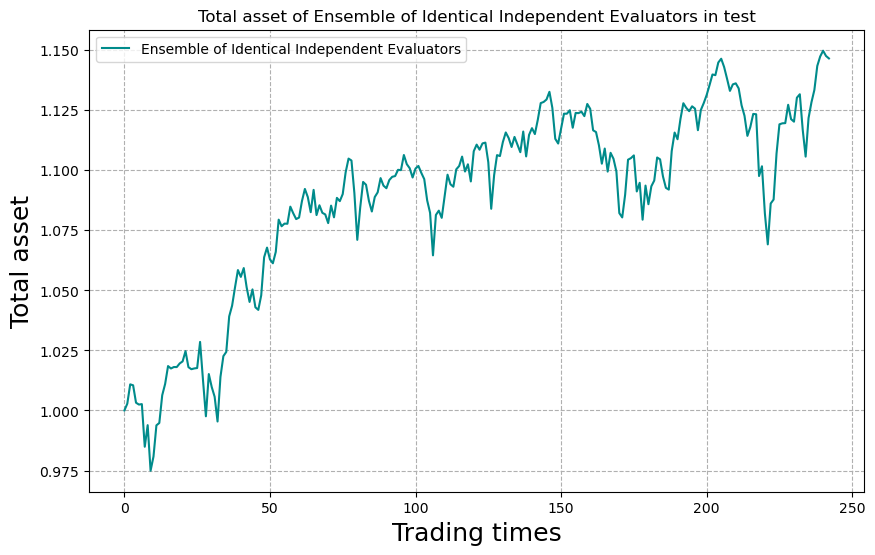

In [53]:
import pandas as pd

# Test and save results
test_results = trainer.test()  # This returns a numpy array

# Assuming the structure of test_results is known, convert it to a DataFrame
columns = ["date", "predicted_high", "predicted_low", "actual_high", "actual_low"]  # Adjust based on the data returned
test_results_df = pd.DataFrame(test_results, columns=columns)

# Save results to a CSV file
test_results_path = os.path.join(work_dir, "test_results_with_high_low.csv")
test_results_df.to_csv(test_results_path, index=False)
print(f"Test results saved to: {test_results_path}")

# Plot results
plot(trainer.test_environment.save_asset_memory(), alg="EIIE")


In [45]:
# Load test results
import pandas as pd

test_results_path = os.path.join(work_dir, "test_results_with_high_low.csv")
results_df = pd.read_csv(test_results_path)

# Query by date
def query_predictions(date, results_df):
    result = results_df[results_df['date'] == date]
    if result.empty:
        return f"No data available for the date: {date}"
    return result.to_dict(orient='records')[0]

# Example query
date_to_query = "2023-01-01"
result = query_predictions(date_to_query, results_df)
print(result)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\KIIT\\ML Python\\AD Lab\\Stock Shit idc\\TradeMaster\\work_dir/portfolio_management_dj30_eiie_eiie_adam_mse\\test_results_with_high_low.csv'

Train Episode: [1/2]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
| 180.547854%  |   1.141169  | 0.757262%  |  15.031935%  |
+--------------+-------------+------------+--------------+
Valid Episode: [1/2]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
|  9.542356%   |   0.448758  | 2.144272%  |  31.113041%  |
+--------------+-------------+------------+--------------+
Train Episode: [2/2]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
| 180.653828%  |   1.141211  | 0.757524%  |  15.040242%  |
+--------------+-------------+------------+--------------+
Valid Episode: [2/2]
+--------------+-------------+-

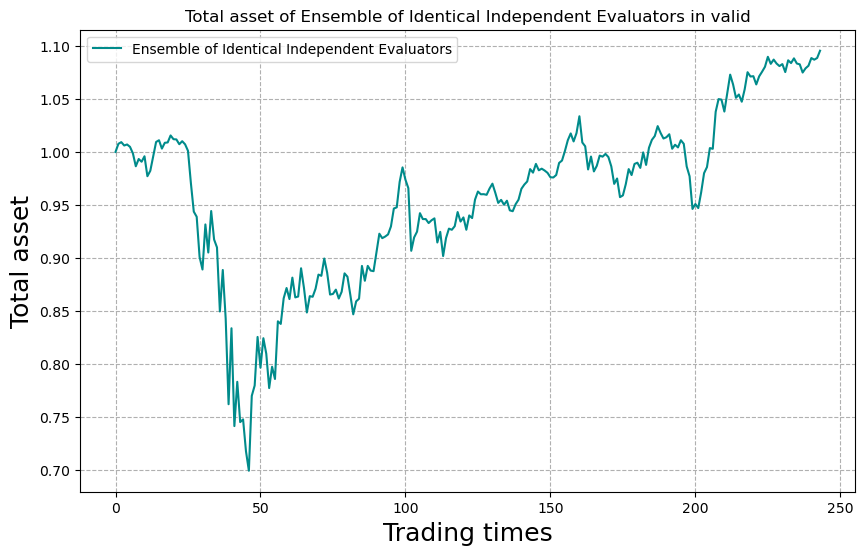

In [122]:
import torch

# After training is completed, save the model
def save_model(actor, critic, work_dir):
    actor_path = os.path.join(work_dir, 'actor_model.pth')
    critic_path = os.path.join(work_dir, 'critic_model.pth')
    
    torch.save(actor.state_dict(), actor_path)
    torch.save(critic.state_dict(), critic_path)
    print(f"Models saved at {actor_path} and {critic_path}")

# Call save_model function after the training and testing
trainer.train_and_valid()
save_model(act, cri, work_dir)

# Optionally, save other useful files like config or trainer state
cfg.dump(osp.join(work_dir, osp.basename(args.config)))


In [130]:
print(train_environment.tech_indicator_list)  # List of features the model expects


['zopen', 'zhigh', 'zlow', 'zadjcp', 'zclose', 'zd_5', 'zd_10', 'zd_15', 'zd_20', 'zd_25', 'zd_30']


Earliest valid target date: 2012-01-09 00:00:00


In [152]:
import torch
import pandas as pd
import os

# Define a function to load the saved models
def load_model(actor, critic, work_dir):
    actor_path = os.path.join(work_dir, 'actor_model.pth')
    critic_path = os.path.join(work_dir, 'critic_model.pth')
    
    # Load the state_dict for the actor and critic
    actor.load_state_dict(torch.load(actor_path))
    critic.load_state_dict(torch.load(critic_path))
    
    # Set the models to evaluation mode
    actor.eval()
    critic.eval()
    print(f"Models loaded from:\nActor: {actor_path}\nCritic: {critic_path}")

# Initialize actor and critic networks (ensure consistency with training configuration)
act = build_net(cfg.act)  # Actor model
cri = build_net(cfg.cri)  # Critic model

# Load the models
work_dir = r"C:\Users\KIIT\ML Python\AD Lab\Stock Shit idc\TradeMaster\work_dir/portfolio_management_dj30_eiie_eiie_adam_mse"
load_model(act, cri, work_dir)

# Load the dataset to test on (replace 'path_to_data.csv' with your dataset path)
data_path = "data.csv"
df = pd.read_csv(data_path)

# Ensure the date column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Function to prepare features for prediction
# Function to prepare features for prediction
def prepare_features(df, target_date, look_back_days=20):
    """
    Prepares the features for the given target date using historical data.
    Skips processing if the target date is too early.
    """
    # Define the required features based on what the model expects
    required_features = ['zopen', 'zhigh', 'zlow', 'zadjcp', 'zclose', 
                         'zd_5', 'zd_10', 'zd_15', 'zd_20', 'zd_25', 'zd_30']

    # Calculate the earliest valid date dynamically
    min_valid_date = df['date'].min() + pd.Timedelta(days=look_back_days)

    # Skip processing for invalid dates
    if target_date < min_valid_date:
        print(f"Skipping {target_date}: Not enough data (need at least {look_back_days} days of history).")
        return None  # Return None to indicate skipping

    # Filter data up to the target date and ensure it contains enough history
    historical_data = df[df['date'] < target_date].tail(look_back_days)
    if len(historical_data) < look_back_days:
        print(f"Skipping {target_date}: Insufficient data after filtering.")
        return None  # Return None to indicate skipping

    # Ensure all required features are present
    if not all(feature in historical_data.columns for feature in required_features):
        missing_features = [f for f in required_features if f not in historical_data.columns]
        print(f"Skipping {target_date}: Missing required features: {missing_features}")
        return None  # Return None to indicate skipping

    # Extract and convert features to tensor
    features = historical_data[required_features].values  # Shape: (look_back_days, 11)
    features_tensor = torch.tensor(features, dtype=torch.float32).unsqueeze(0).unsqueeze(1)  # Shape: (1, 1, 20, 11)

    return features_tensor


# Prepare to collect predictions and compare with real values
results = []

# Iterate over dates in the dataset for prediction
for idx, row in df.iterrows():
    target_date = row['date']
    
    # Ensure there is enough historical data for the prediction
    if idx < 20:  # Skip dates with insufficient historical data
        continue
    
    # Prepare features for the target date
    features = prepare_features(df, target_date)
    
    # Skip if no features were prepared (e.g., insufficient data or missing features)
    if features is None:
        continue
    
    # Predict high and low using the actor model
    with torch.no_grad():  # No gradient tracking for inference
        predicted_action = act(features)
    
    # Assuming predicted_action outputs high and low values directly
    predicted_high = predicted_action[0, 0].item()  # First value is predicted high
    predicted_low = predicted_action[0, 1].item()   # Second value is predicted low
    
    # Append the results (date, predicted high, predicted low, real high, real low)
    results.append({
        'date': target_date,
        'predicted_high': predicted_high,
        'predicted_low': predicted_low,
        'real_high': row['high'],
        'real_low': row['low']
    })

# Convert results to a DataFrame for analysis
results_df = pd.DataFrame(results)

# Save results to CSV for reference
results_df.to_csv("predictions_vs_real.csv", index=False)

# Print a preview of the results
print(results_df.head())

# Compare predicted vs real high-low for a specific target date
specific_date = '2014-01-04'
comparison = results_df[results_df['date'] == specific_date]
if not comparison.empty:
    print(f"Comparison for {specific_date}:\n{comparison}")
else:
    print(f"No data available for {specific_date}")


Models loaded from:
Actor: C:\Users\KIIT\ML Python\AD Lab\Stock Shit idc\TradeMaster\work_dir/portfolio_management_dj30_eiie_eiie_adam_mse\actor_model.pth
Critic: C:\Users\KIIT\ML Python\AD Lab\Stock Shit idc\TradeMaster\work_dir/portfolio_management_dj30_eiie_eiie_adam_mse\critic_model.pth
Skipping 2012-01-04 00:00:00: Not enough data (need at least 20 days of history).
Skipping 2012-01-04 00:00:00: Not enough data (need at least 20 days of history).
Skipping 2012-01-04 00:00:00: Not enough data (need at least 20 days of history).
Skipping 2012-01-04 00:00:00: Not enough data (need at least 20 days of history).
Skipping 2012-01-04 00:00:00: Not enough data (need at least 20 days of history).
Skipping 2012-01-04 00:00:00: Not enough data (need at least 20 days of history).
Skipping 2012-01-04 00:00:00: Not enough data (need at least 20 days of history).
Skipping 2012-01-04 00:00:00: Not enough data (need at least 20 days of history).
Skipping 2012-01-04 00:00:00: Not enough data (need 

In [153]:
print("hello")

hello


In [164]:
# Assuming normalization during training was done using mean and std
# Replace these values with the actual mean and std used during training
mean_high = df['high'].mean()
std_high = df['high'].std()
mean_low = df['low'].mean()
std_low = df['low'].std()

# Denormalize predicted values
results = []
for idx, row in df.iterrows():
    target_date = row['date']
    
    # Ensure there is enough historical data for the prediction
    if idx < 20:  # Skip dates with insufficient historical data
        continue
    
    # Prepare features for the target date
    features = prepare_features(df, target_date)
    
    # Skip if no features were prepared (e.g., insufficient data or missing features)
    if features is None:
        continue
    
    # Predict high and low using the actor model
    with torch.no_grad():  # No gradient tracking for inference
        predicted_action = act(features)
    
    # Assuming predicted_action outputs normalized high and low values directly
    predicted_high = predicted_action[0, 0].item()  # First value is predicted high
    predicted_low = predicted_action[0, 1].item()   # Second value is predicted low
    
    # Denormalize predictions
    denormalized_high = predicted_high * std_high + mean_high
    denormalized_low = predicted_low * std_low + mean_low
    
    # Append the results (date, predicted high, predicted low, real high, real low)
    results.append({
        'date': target_date,
        'predicted_high': denormalized_high,
        'predicted_low': denormalized_low,
        'real_high': row['high'],
        'real_low': row['low']
    })

# Convert results to a DataFrame for analysis
results_df = pd.DataFrame(results)

# Save results to CSV for reference
results_df.to_csv("predictions_vs_real.csv", index=False)

# Print a preview of the results
print(results_df.head())

# Compare predicted vs real high-low for a specific target date
specific_date = '2014-01-04'
comparison = results_df[results_df['date'] == specific_date]
if not comparison.empty:
    print(f"Comparison for {specific_date}:\n{comparison}")
else:
    print(f"No data available for {specific_date}")


Skipping 2012-01-04 00:00:00: Not enough data (need at least 20 days of history).
Skipping 2012-01-04 00:00:00: Not enough data (need at least 20 days of history).
Skipping 2012-01-04 00:00:00: Not enough data (need at least 20 days of history).
Skipping 2012-01-04 00:00:00: Not enough data (need at least 20 days of history).
Skipping 2012-01-04 00:00:00: Not enough data (need at least 20 days of history).
Skipping 2012-01-04 00:00:00: Not enough data (need at least 20 days of history).
Skipping 2012-01-04 00:00:00: Not enough data (need at least 20 days of history).
Skipping 2012-01-04 00:00:00: Not enough data (need at least 20 days of history).
Skipping 2012-01-04 00:00:00: Not enough data (need at least 20 days of history).
Skipping 2012-01-05 00:00:00: Not enough data (need at least 20 days of history).
Skipping 2012-01-05 00:00:00: Not enough data (need at least 20 days of history).
Skipping 2012-01-05 00:00:00: Not enough data (need at least 20 days of history).
Skipping 2012-01

In [165]:
print("hello")

hello
